In [2]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools
from scipy import interpolate
 
import csv
import matplotlib.cm as cm

In [3]:
# VARIABLES

file_name = 'IC_raw_spectra_(2019_02_25_'

#path_raw = 'H:/MSci Project/sand_outside' #path containing all raw spectra RACHEL
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/sand_outside' #path containing all raw spectra
file_path_tau = path_raw + "/Laura_simulations"

In [4]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    
    return spectrum1,spectrum2,spectrum3,spectrum4

In [5]:
#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + '{0:03}'.format(i) + '.txt', separator=',', rowstoskip=None, head=None).iloc[1,0]
    temp_check_float = float(temp_check.split()[0])
    if temp_check_float == 0.0:
        m_numbers.pop(i)

files = [file_name + '{0:03}'.format(num) + '.txt' for num in m_numbers][:-2] #final list of strings of file names, in order

In [6]:
columns_ = ['RT0','RT1','RT2','Dummy','RT3','RT4','HBB_temp','CBB_temp','Time', 'Orientation'] #columns for Pandas DataFrame

read_temps = []

for i in np.arange(0,len(files)):
    #Go through files and retrieve temperatures and orientations of spectra
    read_temps.append( read_file(path_raw, files[i], separator=',', rowstoskip=None, head=None).iloc[1:5,0].str.split() )
    read_temps_flat = list(itertools.chain(*read_temps)) #flatten read_temps_i

times_temps = pd.DataFrame(read_temps_flat, columns = columns_)

In [7]:
wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values

wavenums_cut = [wn for wn in wavenums if wn>400]
wavenums_min_ind = [i for i,x in enumerate(wavenums) if x >400][0]

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [8]:
wavenums_cut

[400.07420000000002,
 400.31540000000001,
 400.55650000000003,
 400.79770000000002,
 401.03879999999998,
 401.27999999999997,
 401.52109999999999,
 401.76229999999998,
 402.00349999999997,
 402.24459999999999,
 402.48579999999998,
 402.7269,
 402.96809999999999,
 403.20920000000001,
 403.4504,
 403.69150000000002,
 403.93270000000001,
 404.1739,
 404.41500000000002,
 404.65620000000001,
 404.89729999999997,
 405.13850000000002,
 405.37959999999998,
 405.62079999999997,
 405.86189999999999,
 406.10309999999998,
 406.3442,
 406.58539999999999,
 406.82650000000001,
 407.0677,
 407.30880000000002,
 407.55000000000001,
 407.7912,
 408.03230000000002,
 408.27350000000001,
 408.51459999999997,
 408.75580000000002,
 408.99689999999998,
 409.23809999999997,
 409.47919999999999,
 409.72039999999998,
 409.9615,
 410.20269999999999,
 410.44380000000001,
 410.685,
 410.92610000000002,
 411.16730000000001,
 411.4085,
 411.64960000000002,
 411.89080000000001,
 412.13189999999997,
 412.37310000000002,

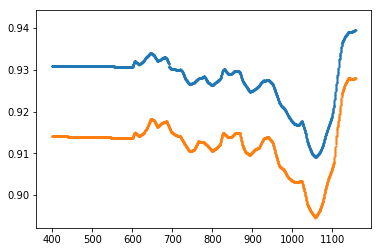

In [9]:
bb_25_em = read_file(path_raw, 'red.csv', ',', rowstoskip=None, head=None)
bb_150_em = read_file(path_raw, 'green.csv', ',', rowstoskip=None, head=None)

bb_25_em.loc[len(bb_25_em)]=0
bb_25_em = bb_25_em.shift()
bb25_series = pd.Series([0, bb_25_em.loc[1][1]])
bb_25_em.loc[0] = bb25_series

bb_150_em.loc[len(bb_150_em)]=0
bb_150_em = bb_150_em.shift()
bb150_series = pd.Series([0, bb_150_em.loc[1][1]])
bb_150_em.loc[0] = bb150_series

f_ems_cbb = interpolate.interp1d(bb_25_em[0], bb_25_em[1])
f_ems_150 = interpolate.interp1d(bb_150_em[0], bb_150_em[1])

#blackbody correction
cbb_em = []
hbb_em = []

for wn in wavenums_cut:
    cold = f_ems_cbb(wn)
    hot = f_ems_150(wn)
    cbb_em.append(cold)
    hbb_em.append((hot-cold)*45/125+cold)

plt.scatter(wavenums_cut, hbb_em, s=1)
plt.scatter(wavenums_cut, cbb_em, s=1)


plt.show()

In [10]:
def inv_resp_function(hbb_index, cbb_index):
    
    hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
    cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
    
    V_diff = np.array(hbb_spectrum)-np.array(cbb_spectrum)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    temp_average_c = times_temps.at[cbb_index,'CBB_temp']
    rad_diff = []

    # blackbody correction
    for (wn, hot_em, cold_em) in zip(wavenums_cut, hbb_em, cbb_em):
        hot_rad = planck(wn, float(temp_average_h)+273.15)
        real_h_rad = hot_em*hot_rad
        cold_rad = planck(wn, float(temp_average_c)+273.15)
        real_c_rad = cold_em*cold_rad
        
        diff = real_h_rad - real_c_rad
        rad_diff.append(diff)
    
    def division(raw_val,planck_val):
        if raw_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div

    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)

    return(ratio)


def plot_planck(t, wns):
    radiances = []
    for w in wns:
        radiances.append(planck(w, t+273.15))
    return radiances

rad_diff = inv_resp_function(hbb_spectrum, cbb_spectrum)

plt.scatter(wavenums_cut, rad_diff)
plt.show()

In [11]:
# choose files that are taken around one of Laura's transmissions

transmission_filenames = ['2239_2799','2041_3211', '2103_3063', '2096_2922', '2046_3048'] #
hbb_indeces = [343, 432, 528, 624, 720] #
cbb_indeces = [344, 440, 519, 615, 711] #
sky_indeces = [352, 431, 503, 599, 736] #
surface_indeces = [335, 448, 525, 619, 712] #
atm_temp = [22.39, 20.41, 21.03, 20.96, 20.46] #
surf_temp = [19.2, 18.1, 17.3, 17.1, 16.8] #
times = ['Newman Data', 'Feldman Data', '13:48', '14:27', '15:07', '15:48', '16:28', '13:48', '14:27', '15:07', '15:48', '16:28']

In [12]:
newman_data = read_file(path_raw, 'Newman_data.csv', ',', rowstoskip=None, head=None)
feldman_data = read_file(path_raw, 'feldman_data.csv', ',', rowstoskip=None, head=None)

In [13]:
em_without_correction = read_file(path_raw, 'emissivities.csv', '\t', rowstoskip=None, head=None)

wns_before = em_without_correction[0]
em_wo_corr_1 = em_without_correction[1]
em_wo_corr_2 = em_without_correction[2]
em_wo_corr_3 = em_without_correction[3]
em_wo_corr_4 = em_without_correction[4]
em_wo_corr_5 = em_without_correction[5]

In [15]:
wns_before

0        529.8150
1        530.0562
2        530.2973
3        530.5385
4        530.7796
5        531.0208
6        531.2619
7        531.5031
8        531.7443
9        531.9854
10       532.2266
11       532.7089
12       532.9500
13       533.4323
14       533.6735
15       534.6381
16       537.5319
17       537.7731
18       538.2554
19       538.4965
20       538.7377
21       538.9788
22       539.2200
23       539.9435
24       540.1846
25       541.8727
26       542.1138
27       542.3550
28       542.5961
29       542.8373
          ...    
1825    1148.1334
1826    1148.3746
1827    1148.6158
1828    1148.8569
1829    1149.0981
1830    1149.3392
1831    1149.5804
1832    1149.8215
1833    1150.0627
1834    1150.3038
1835    1150.5450
1836    1150.7861
1837    1151.0273
1838    1151.2684
1839    1151.5096
1840    1151.7507
1841    1151.9919
1842    1152.2330
1843    1152.7155
1844    1152.9565
1845    1153.1978
1846    1153.4388
1847    1153.6801
1848    1153.9211
1849    11

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/Users/micol/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


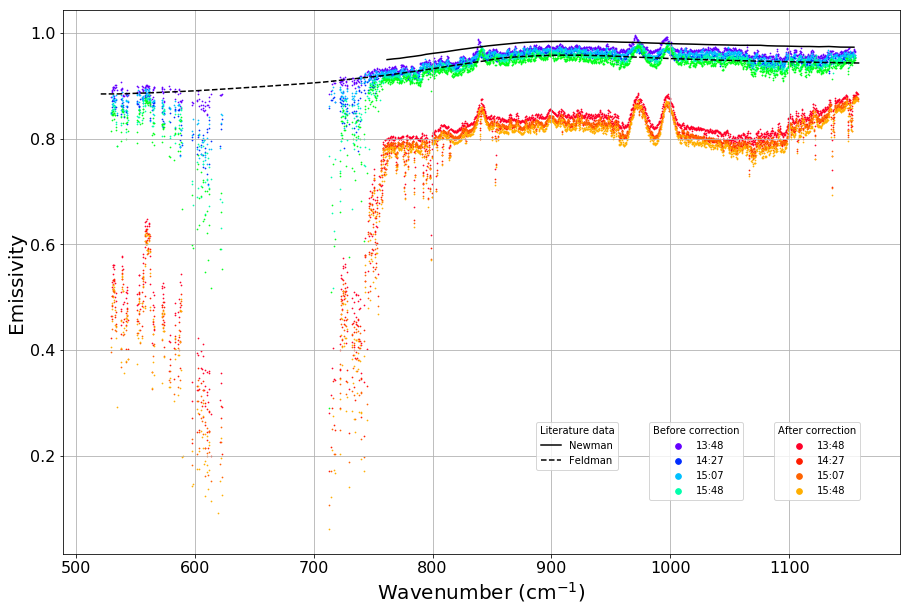

In [14]:
fig = plt.figure(figsize=(15,10))
colors = cm.gist_rainbow(np.linspace(0, 1, 20)) # last number is number of colours you want


for (t_file, hbb_index, cbb_index, sky_index, surface_index, atm_t, surf_t, color, time) in zip(transmission_filenames, hbb_indeces, cbb_indeces, sky_indeces, surface_indeces, atm_temp, surf_temp, colors[:len(atm_temp)], times[2:6]):
    
    hbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(hbb_index/4))])[hbb_index%4][wavenums_min_ind:]
    cbb_spectrum = read_raw_spectra(path_raw, files[int(np.floor(cbb_index/4))])[cbb_index%4][wavenums_min_ind:]
    response = inv_resp_function(hbb_index, cbb_index)
    
    temp_average_h = times_temps.at[hbb_index,'HBB_temp']
    radiances_avg_h = []
    for (wn,hot_em) in zip(wavenums_cut, hbb_em):
        hot_rad = planck(wn, float(temp_average_h)+273.15)
        #blackbody correction
        real_h_rad = hot_em*hot_rad
        radiances_avg_h.append(real_h_rad)
    
    sky = read_raw_spectra(path_raw, files[int(np.floor(sky_index/4))])[sky_index%4][wavenums_min_ind:]
    surf = read_raw_spectra(path_raw, files[int(np.floor(surface_index/4))])[surface_index%4][wavenums_min_ind:]

    sky_rad = np.divide((sky-hbb_spectrum), response) + radiances_avg_h
    surf_rad = np.divide((surf-hbb_spectrum), response) + radiances_avg_h

    tau_wn= []
    taus_rtm = []
    trans_file = np.loadtxt(file_path_tau + '/' + t_file +'.txt')
    for i in np.arange(trans_file.shape[0]):
        tau_wn.append(trans_file[i][0])
        taus_rtm.append(trans_file[i][1])
    f_trans = interpolate.interp1d(tau_wn, taus_rtm)
    
    downs = []
    ups = []
    taus = []
    wns =[]
    for i in range(len(wavenums_cut)):
        if f_trans(wavenums_cut[i]) >0.98:
            taus.append(f_trans(wavenums_cut[i]))
            wns.append(wavenums_cut[i])
            downs.append(sky_rad[i])
            ups.append(surf_rad[i])
            
    BBatm = plot_planck(atm_t, wns)
    BBsurf = plot_planck(surf_t, wns)
    
    N1 = np.array(ups)
    N2 = np.array([t**2*d for t, d in zip(taus, downs)])
    N3 = np.array([(1-t**2)*b for t, b in zip(taus, BBatm)])

    N = N1-N2-N3

    D1 = np.array([t*b for t, b in zip(taus, BBsurf)])
    D2 = np.array([t**2*d for t, d in zip(taus, downs)])
    D3 = np.array([t*(1-t)*b for t, b in zip(taus, BBatm)])

    D = D1-D2-D3

    ax = fig.add_subplot(111)

    ax.scatter(wns, N/D, s=0.5, c=color, label=time)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=20)
    plt.ylabel('Emissivity', fontsize=20)

plt.grid()
leg1 = ax.legend(loc=(.85,.1), markerscale=8, title='After correction')

wc1 = ax.scatter(wns_before, em_wo_corr_1, s=0.5, c=colors[-4], label='_')
wc2 = ax.scatter(wns_before, em_wo_corr_2, s=0.5, c=colors[-6], label='_')
wc3 = ax.scatter(wns_before, em_wo_corr_3, s=0.5, c=colors[-8], label='_')
wc4 = ax.scatter(wns_before, em_wo_corr_4, s=0.5, c=colors[-10], label='_')
wc5 = ax.scatter(wns_before, em_wo_corr_5, s=0.5, c=colors[-12], label='_')
leg2 = ax.legend([wc1,wc2, wc3, wc4, wc5],times[2:6], loc=(.7,0.1), markerscale=8, title='Before correction')

new = ax.plot(newman_data[0][0:48], newman_data[1][0:48], 'k', label='Newman')
feld = ax.plot(feldman_data[0][1:51], feldman_data[1][1:51], 'k--', label='Feldman')

plt.legend(['Newman', 'Feldman'], loc=(.565,0.155), markerscale=4, title='Literature data')

ax.add_artist(leg1)
ax.add_artist(leg2)

ax.tick_params(labelsize=16, labelcolor='black')

plt.show()


paper for falt bounce, bnut once in cavity it will bounce several times
will ahve right black in future
can say we had a look for a flat plate but clearly it is too low and probably what is happening, there are multiple reflections inside the cavity
go to 400
include newman for ocean water compared to feldman and show whether it is the salinity that has the effect
could also have naother newman curve for different temperature

TODO

#Corrrect emissivity equation

#do with sand

#see how stable emissivity is over time

#if time, look at BB emissivity paper and incorporate that in our model. Take red line in figures 5,6 or interpolate between two 

#see whether it has a big effect on emissivity - should see a jump around 1000 wavenums

uncertainyt in atm temp - what does it do to emissivity
uncertainty in transmittance - what does it do


#Maybe plot our emissivities on top of Newman values. Maybe with uncertainties we are in the range
In the FIR look at FIR for sea water (maybe in supplementary materials). Emissivities went much lower? Difference is wiht salinity
Newman in FIR has not much effect of salinity 

Report: characterise instrument, e values and error analysis, comparison to previous papers

For errors:
     in the code estimate uncertainty in surface temperature, and put it in code keeping everything else constant - see effects of varyinf surf temp and same for all other components in the formula.

#Might want to instead of plotting emissivities for the sensistivyt, plot the difference between the original emissivity and the final one.

Estimate uncertainties on different quantities to get an estimate of percentage uncertainty as function of wavenumber

Find a way to highlight the unperturbed quantity in the legend

Could also look at emissivity distribution like they do in Bellisario Figure 7d